In [19]:
import numpy as np, agama
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import astropy.units as u
import os

In [20]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

34.48275862068965


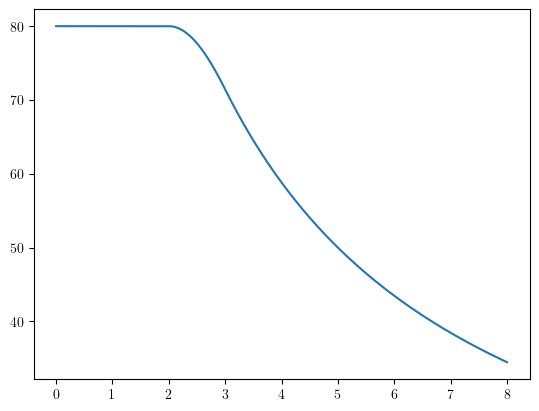

In [21]:
'''Create barred potential'''

# Function to calculate relative bar strength
def calc_bar_frac(t, t0, t1):
    xi = 2*(t - t0)/(t1 - t0) - 1
    bar_frac = np.clip(3/16*xi**5 - 5/8*xi**3 + 15/16*xi + 1/2, 0, 1)

    return bar_frac

from scipy.integrate import quad

def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 80
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Potential parameters
R_sun = 8.178
vcirc_sun = 236.9
a_NFW = 19.6

# Array of times for potential creation
bartime = np.linspace(0, tf, 1001)


Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

for i in range(len(bartime)):
    Omega_b[i] = calc_Omega_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)


# Omega_b = Omega_b_1 / (1 + eta*Omega_b_1*bartime)
# phi_b = 1/eta * np.log(1 + eta*Omega_b_1*bartime)
bar_frac = calc_bar_frac(bartime, t0, t1)

plt.plot(bartime, Omega_b)
print(Omega_b[-1])

In [22]:
'''Save non-axisymmetric potential components'''

agama_pot_path = '/export/linnunrata/ucapdil/agama_potentials/'#'/Users/adam/Documents/ucl/agama_potentials/'

pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'
pot_nonaxi_path = 'MWPotentialHunter24_nonaxi.ini'

pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path)
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)
pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

pot_nonaxi = agama.Potential(pot_bar_baryon, pot_axi_baryon_neg)

# pot_axi = make_pot(vcirc_sun, a_NFW, pot_axi_baryon)


# S = 39/Omega_b[-1]
# A = (bar_frac * S)[-1]

# print(A)

# pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=[A,S])
# # And the axisymmetrised, scaled baryonic potential with equal but negative mass
# pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-A,S])

# # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
# # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
# pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

# R_grid = np.linspace(0.1, 20, 1001)
# vcirc_grid = (-R_grid * pot.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

# plt.plot(R_grid, vcirc_grid)

print(pot_nonaxi)



CompositePotential{ CompositePotential{ Multipole, CylSpline }, Scaled CompositePotential{ Multipole, CylSpline } } (symmetry: Triaxial)


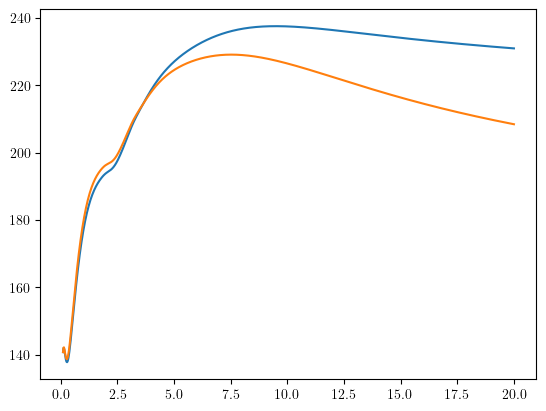

In [23]:
'''Make slowing barred potential'''

# First construct axisymmetric potential from baryonic Hunter24 potential + custom NFW
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, a_NFW, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # DM halo density normalisation
    rho_0 = R_sun * vcirc_dark**2 / (4 * np.pi * agama.G * a_NFW**3) * (np.log(1 + R_sun/a_NFW) - 1/(1 + a_NFW/R_sun))**(-1)

    # Make DM potential
    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    # And total potential
    pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

    return pot_mod

pot_axi = make_pot(vcirc_sun, a_NFW, pot_axi_baryon)


# Then make full time-dependent potential with growing and slowing bar
def make_potential(bartime, Omega_b, phi_b, bar_frac):
    
    S = 39/Omega_b
    A = bar_frac * S

    # Load full, scaled, rotated baryonic potential
    pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
    # And the axisymmetrised, scaled baryonic potential with equal but negative mass
    pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

    # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
    # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
    pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

    return pot


pot = make_potential(bartime, Omega_b, phi_b, bar_frac)


# Plot rotation curve of axisymmetric potential
R_grid = np.linspace(0.1, 20, 1001)
vcirc_grid = (-R_grid * pot_axi.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

plt.plot(R_grid, vcirc_grid)

pot_axi_Hunter = agama.Potential(file=agama_pot_path+'MWPotentialHunter24_axi.ini')
vcirc_grid = (-R_grid * pot_axi_Hunter.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

plt.plot(R_grid, vcirc_grid)



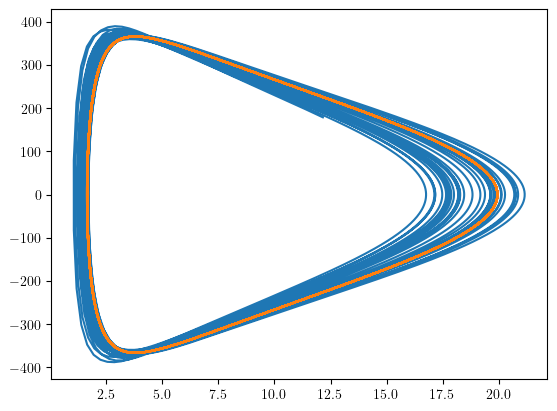

In [24]:
'''Test with individual orbits'''

ic = [8.2, 0, 0, 300, 100, 0]

traj = agama.orbit(ic=ic, potential=pot, time=tf, trajsize=10001)[1]

R_sim = np.linalg.norm(traj[:,0:2], axis=-1)
phi_sim = (np.arctan2(traj[:,1], traj[:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = traj[:,0:3] * [1, 1, 0] / R_sim[:,None]
vR_sim = (traj[:,3:6] * R_hat).sum(axis=-1)

plt.plot(R_sim, vR_sim)


traj = agama.orbit(ic=ic, potential=pot_axi, time=tf, trajsize=10001)[1]

R_sim = np.linalg.norm(traj[:,0:2], axis=-1)
phi_sim = (np.arctan2(traj[:,1], traj[:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = traj[:,0:3] * [1, 1, 0] / R_sim[:,None]
vR_sim = (traj[:,3:6] * R_hat).sum(axis=-1)

plt.plot(R_sim, vR_sim)


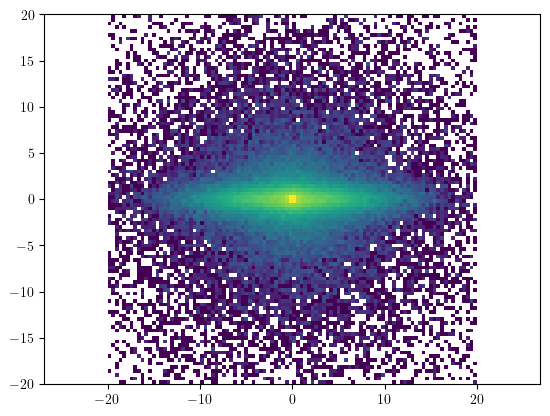

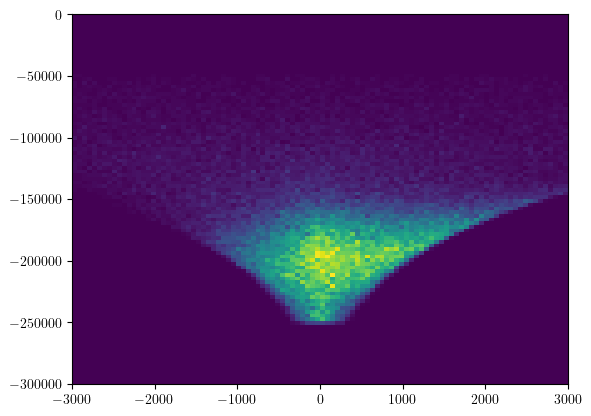

88527


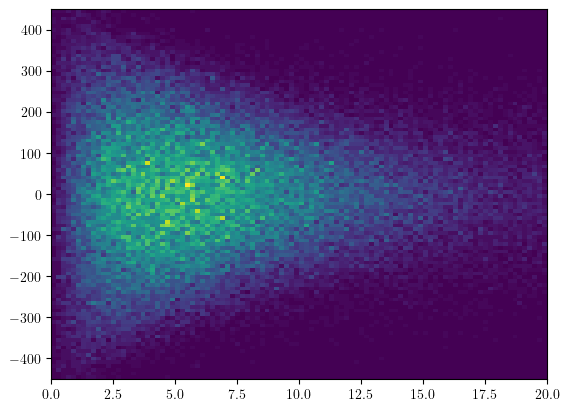

In [84]:
'''Initial distribution function'''

gamma = 2.3
beta = 4.6

# Create density profile from which to construct df
density = agama.Density(type='spheroid', mass=1e9, alpha=1, beta=beta, gamma=gamma, scaleRadius=25)
df_halo = agama.DistributionFunction(type='quasispherical', density=density, potential=pot_axi)

# df_halo = agama.DistributionFunction(type='DoublePowerLaw', norm=1e9, J0=100, slopeIn=0, slopeOut=4, coefJrIn=0.05, coefJrOut=0.05, coefJzIn=2.8, coefJzOut=2.8, Jcutoff=500)

df_disc = agama.DistributionFunction(type='exponential', mass=1e9, Jphi0=400, Jz0=200, Jr0=5000)

#df_disc = agama.DistributionFunction(type='exponential', mass=1e9, Jphi0=400, Jz0=200, Jr0=1100)

df = df_disc #agama.DistributionFunction(df_disc, df_halo)

Nbody = int(1e5)

ic, mass = agama.GalaxyModel(pot_axi, df).sample(Nbody)

R = np.linalg.norm(ic[:,0:2], axis=1)
phi = np.arctan2(ic[:,1], ic[:,0])

R_hat = ic[:,0:3] * [1, 1, 0] / R[:,None]
vR = (ic[:,3:6] * R_hat).sum(axis=1)

Lz = np.cross(ic[:,0:3], ic[:,3:6])[:,2]
E = 0.5 * (ic[:,3:6]**2).sum(axis=-1) + pot_axi.potential(ic[:,0:3])



cut = (E > -2.5e5)*(E < -0.5e5)#*(R > 5)*(R < 20)*(abs(ic[:,2]) < 2)
#cut = (Lz > -1000)*(Lz < 1000)#*(R > 5)*(R < 20)*(abs(ic[:,2]) < 2)

plt.hist2d(ic[:,0], ic[:,2], bins=np.linspace(-20, 20, 101), norm=mcolors.LogNorm())
plt.axis('equal')
plt.show()
plt.close()

plt.hist2d(Lz[cut], E[cut], bins=(np.linspace(-3000, 3000, 101), np.linspace(-3e5, 0, 101)))

plt.show()
plt.close()

R_bins = np.linspace(0, 20, 101)
vR_bins = np.linspace(-450, 450, 101)
plt.hist2d(R[cut], vR[cut], bins=(R_bins, vR_bins))




# plt.hist(R[cut], bins=100)

ic = ic[cut]

print(len(ic))





In [85]:
'''Run simulation'''

o = agama.orbit(ic=ic, potential=pot, time=tf, trajsize=11)

88527 orbits complete (183 orbits/s)


In [29]:
'''Save array'''

sim_path = '/export/linnunrata/ucapdil/sims/'

np.save(sim_path+'trajs', o)

In [97]:
o = np.load(sim_path+'trajs.npy', allow_pickle=True)

[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]
[80.         80.         80.         78.49293493 68.49315001 58.82352941
 51.54639023 45.87156024 41.32231356 37.59398577 34.48275862]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3000., -2940., -2880., -2820., -2760., -2700., -2640., -2580.,
        -2520., -2460., -2400., -2340., -2280., -2220., -2160., -2100.,
        -2040., -1980., -1920., -1860., -1800., -1740., -1680., -1620.,
        -1560., -1500., -1440., -1380., -1320., -1260., -1200., -1140.,
        -1080., -1020.,  -960.,  -900.,  -840.,  -780.,  -720.,  -660.,
         -600.,  -540.,  -480.,  -420.,  -360.,  -300.,  -240.,  -180.,
         -120.,   -60.,     0.,    60.,   120.,   180.,   240.,   300.,
          360.,   420.,   480.,   540.,   600.,   660.,   720.,   780.,
          840.,   900.,   960.,  1020.,  1080.,  1140.,  1200.,  1260.,
         1320.,  1380.,  1440.,  1500.,  1560.,  1620.,  1680.,  1740.,
         1800.,  1860.,  1920.,

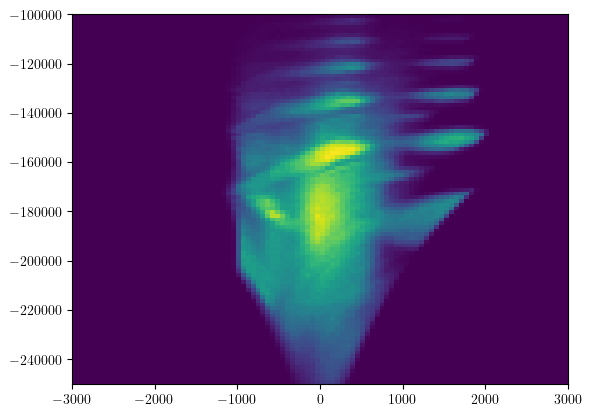

In [98]:
'''Calculate simulation quantities'''

ts = o[:,0][0]

Omega_b = np.zeros(len(ts))
phi_b = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

print(ts)
print(Omega_b)

trajs = np.stack(o[:,1]).transpose((1,0,2))

R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)

Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

E_sim = np.zeros(Lz_sim.shape)

for i in range(E_sim.shape[0]):
    E_sim[i] = 0.5 * (trajs[i,:,3:6]**2).sum(axis=-1) + pot_axi.potential(trajs[i,:,0:3])


plt.hist2d(Lz_sim[-1], E_sim[-1], bins=(np.linspace(-3000, 3000, 101), np.linspace(-2.5e5, -1e5, 101)))


In [101]:
# Function to calculate exact OLR orbit in given axisymmetric potential with given pattern speed and Lz

from scipy.interpolate import CubicSpline

def calc_res_orbit(pot, Omega_b, res_ratio_list, Lz):
    # Create ActionFinder to compute frequencies
    # af = agama.ActionFinder(pot)

    # Make grid of initial conditions at Sun's radius
    N_grid = 41
    vR_grid = np.linspace(1, 400, N_grid)
    ic = np.array([R_sun*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_sun*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    o = agama.orbit(ic=ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001, verbose=False)
    ts = o[:,0][0]
    orbits = np.stack(o[:,1]).transpose((1,0,2))
    # print('orbit integration time =', end_time - start_time)
    
    R_orbits = np.linalg.norm(orbits[:,:,0:2], axis=-1)
    
    R_hat = orbits[:,:,0:3] * [1, 1, 0] / R_orbits[:,:,None]   
    vR_orbits = (orbits[:,:,3:6] * R_hat).sum(axis=-1)
    
    
    phi_orbits = np.arctan2(orbits[:,:,1], orbits[:,:,0]) + Omega_b * ts[:,None]

    

    phi_orbits_unwrap = np.unwrap(phi_orbits, axis=0)

    apo_indices = np.where((vR_orbits[:-1] > 0)*(vR_orbits[1:] < 0))

    # Calculate radial periods and frequencies
    T_R = np.full(vR_orbits.shape[1], np.nan)
    Omega_phi = np.full(vR_orbits.shape[1], np.nan)

    

    for m in range(vR_orbits.shape[1]):
        column_true_indices = apo_indices[0][apo_indices[1] == m]  # Get the indices of True values in column m
        if len(column_true_indices) >= 2:
            T_R[m] = (column_true_indices[1] - column_true_indices[0]) * (ts[1] - ts[0])
            Omega_phi[m] = (phi_orbits_unwrap[column_true_indices[1],m] - phi_orbits_unwrap[column_true_indices[0],m]) / (ts[column_true_indices[1]] - ts[column_true_indices[0]])


    

    # print('Loop time =', end_time-start_time)
    
    Omega_R = 2*np.pi / T_R

    freq_ratio = -(Omega_phi - Omega_b)/Omega_R

    vR_grid_fine = np.linspace(vR_grid[0], vR_grid[-1], 1001)
    freq_ratio_inter = np.interp(vR_grid_fine, vR_grid, freq_ratio)


    # act, ang, freq = af(ic, angles=True)

    # freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    vR_func_list = []

    for i in range(len(res_ratio_list)):
        res_ratio = res_ratio_list[i]
        res_dist = abs(freq_ratio_inter - res_ratio)

        res_index = np.nanargmin(res_dist)
        res_ic = ic[0]
        res_ic[3] = vR_grid_fine[res_index]

        # plt.plot(res_dist)

        res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=2, trajsize=1001)[1]

        R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
        R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
        vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)


        # try:
        first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
        first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

        index_inner = np.argmin(R_orbit)
        index_outer = np.argmax(R_orbit)
        R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
        vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

        # plt.plot(R_orbit_cut, vR_orbit_cut)

        vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)), extrapolate=False)
        vR_func_list.append(vR_func)

        # # plt.plot(R_orbit_cut, vR_orbit_cut)

        # except:

        #     plt.plot(R_orbit)
        #     plt.show()
        #     plt.close()

        #     plt.plot(vR_orbit)
        #     plt.show()
        #     plt.close()

        #     first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
        #     first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

        #     index_inner = np.argmin(R_orbit)
        #     index_outer = np.argmax(R_orbit)
        #     R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
        #     vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

            
        #     # order = np.argsort(R_orbit)

        #     vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)), extrapolate=False)
        #     vR_func_list.append(vR_func)
        
        # print('Cubic spline time =', end_time-start_time)
    # print('total time =', tf-t0)

    return vR_func_list




34.48275862068965


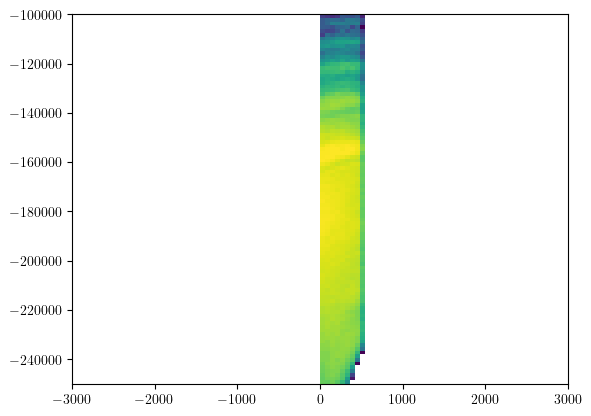

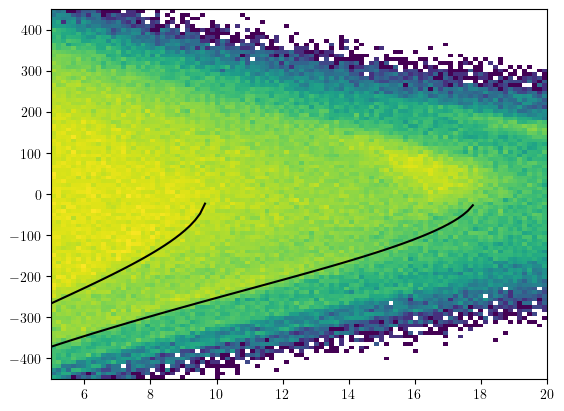

In [103]:
R_bins = np.linspace(5, 20, 101)
vR_bins = np.linspace(-450, 450, 101)

snap = -1

print(Omega_b[snap])

cut = (Lz_sim[snap] > 0)*(abs(Lz_sim[snap]) < 500)*(R_sim[snap] > 0)*(R_sim[snap] < 20)*(phi_sim[snap]%np.pi > 2/3*np.pi)*(phi_sim[snap]%np.pi < np.pi)#*(abs(trajs[snap,:,2]) < 1)


res_ratio_list = [0,0.5]#[-0.5, 0, 0.25, 0.5, 1]
Lz_res = 250
vR_res = calc_res_orbit(pot_axi, Omega_b[snap], res_ratio_list, Lz_res)

af = agama.ActionFinder(pot_axi)
act = af(trajs[snap])


# plt.scatter(Lz_sim[0], E_sim[0], s=1)
plt.hist2d(Lz_sim[snap,cut], E_sim[snap,cut], bins=(np.linspace(-3000, 3000, 101), np.linspace(-2.5e5, -1e5, 101)), norm=mcolors.LogNorm())


plt.show()
plt.close()


plt.hist2d(R_sim[snap,cut], vR_sim[snap,cut], bins=(R_bins, vR_bins), norm=mcolors.LogNorm())



for i in range(len(res_ratio_list)):
    plt.plot(R_bins, vR_res[i](R_bins), c='k')


plt.show()
plt.close()




/tmp/ipykernel_787816/3021150145.py:25: RuntimeWarning: invalid value encountered in divide
  hist_antisym = (hist - np.flip(hist, axis=1))/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))


10 orbits complete (26.6 orbits/s)
(1000, 10, 6)


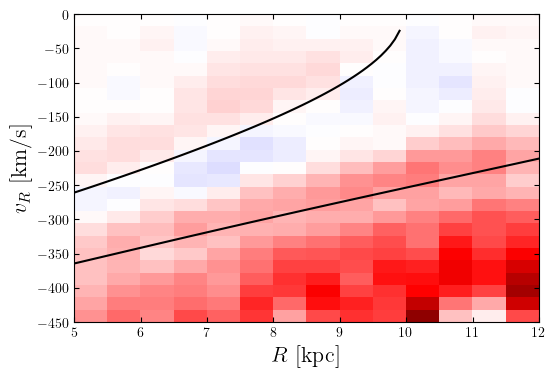

In [113]:
'''Generate mock data from antisymmetric distribution as function of radius'''
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

vR_bins = np.linspace(-450, 450, 51)
vphi_bins = np.linspace(0, 100, 11)

vR_binwidth = vR_bins[1] - vR_bins[0]

R_bins = np.linspace(5, 12, 15)
R_bincentres = (R_bins[1:] + R_bins[:-1])/2


snap = -1

# Plot R-vR antisymmetric histogram
cut = (Lz_sim[snap] > 0)*(abs(Lz_sim[snap]) < 500)*(phi_sim[snap]%np.pi > 2/3*np.pi)*(phi_sim[snap]%np.pi < np.pi)#*(abs(trajs[snap,:,2]) < 2)#*(vphi_data > 0)*(abs(vphi_data) < 100)#*(eta_data<0.98)#*(logg<3)

hist, _, _ = np.histogram2d(R_sim[snap,cut], vR_sim[snap,cut], bins=(R_bins, vR_bins))

vR_bincentres = 0.5*(vR_bins[1:]+vR_bins[:-1])
vphi_bincentres = 0.5*(vphi_bins[1:]+vphi_bins[:-1])

hist_antisym = (hist - np.flip(hist, axis=1))/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
hist_antisym = np.nan_to_num(hist_antisym)
hist_antisym_smooth = gaussian_filter(hist_antisym, (0,1))

fig, ax = plt.subplots(figsize=(6,4))
ax.imshow(hist_antisym_smooth.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', vmin=-1, vmax=1, origin='lower', interpolation='none', aspect='auto')


res_ratio_list = [0, 0.5]#, 1]

Lz_grid = [500]#np.linspace(20, 500, 11)
R_grid = np.linspace(R_bins[0], R_bins[-1], 101)

for i in range(len(Lz_grid)):
    vR_res = calc_res_orbit(pot_axi, Omega_b[snap], res_ratio_list, Lz_grid[i])

    for j in range(len(res_ratio_list)):
        plt.plot(R_grid, vR_res[j](R_grid), c='k', alpha=1)

# ax.set_xlim(5, 12)
ax.set_ylim(top=0)

# Plot orbits of individual particles
o_test = agama.orbit(ic=trajs[0,1000:1010], potential=pot, time=tf, trajsize=1000)
trajs_test = np.stack(o_test[:,1]).transpose((1,0,2))

print(trajs_test.shape)

R_test = np.linalg.norm(trajs_test[:,:,0:2], axis=-1)
phi_test = (np.arctan2(trajs_test[:,:,1], trajs_test[:,:,0]))# - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = trajs_test[:,:,0:3] * [1, 1, 0] / R_test[:,:,None]
vR_test = (trajs_test[:,:,3:6] * R_hat).sum(axis=-1)

# plt.plot(R_test, vR_test, c='k', alpha=0.1)


ax.set_xlim(R_bins[0], R_bins[-1])

ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

ax.set_xlabel('$R$ [kpc]', fontsize=16)
ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

plt.show()
plt.close()